# U-Net Auto Encoder

The goal of this trial is to use a U-Net Architecture to overfit on a single image and be able to encode and decode that image almost perfectly.

#Setup

1.   Clone Repository / Fetch Files
2.   Change into project directory
3.   Confirm python packages are installed via pip

NOTE: To run Google Colab cells most easily, use `ctrl + enter`

Secondary Note: I use all CAPS variable names to imply they'll be seen again later, it's not great python style though 



In [3]:
!git clone -s git://github.com/gerardrbentley/Pytorch-U-Net-AutoEncoder.git unet-train
!echo ------
%cd unet-train
# Should all be satisfied in colab
!pip install -r requirements.txt
!echo ------
!ls

Cloning into 'unet-train'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 0), reused 16 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 21.26 KiB | 21.26 MiB/s, done.
------
/content/game-segmentation/game-segmentation/unet-train
------
datasets.py		    ml_args.py		requirements.txt
distributed_utils.py	    models.py		train.py
evaluation.py		    overfit-icarus.png	visualize.py
__init__.py		    overfit.png
input_target_transforms.py  README.md


# Running Some Code

We'll start by visualizing the image we want to train on, to make sure we have access to it and it looks right.

In google colab we can't use imshow normally, so we use %matplotlib inline to display

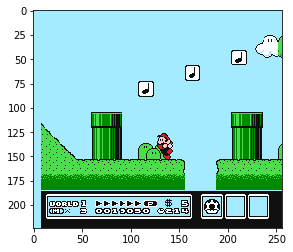

In [0]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
%matplotlib inline
testim = mpimg.imread('overfit.png')
plt.figure()
plt.imshow(testim)

# Loading Up the Neural Network Model

Here we initialize our model and put it on the gpu. We're starting from scratch, so no loading checkpoints

In [17]:
import torch
from models import UNetAuto
MODEL = UNetAuto()

DEVICE = 'cpu'
if torch.cuda.is_available():
  print('Using GPU')
  DEVICE = 'cuda'
  MODEL.to(DEVICE)
else:
  print('Not using GPU. In Colab go to Edit -> Notebook Settings for hardware acceleration')


from torchsummary import summary
summary(MODEL, input_size=(3,224,256))

Using GPU
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 254]             896
              ReLU-2         [-1, 32, 222, 254]               0
       BatchNorm2d-3         [-1, 32, 222, 254]              64
  ReplicationPad2d-4         [-1, 32, 224, 256]               0
            Conv2d-5         [-1, 32, 222, 254]           9,248
              ReLU-6         [-1, 32, 222, 254]               0
       BatchNorm2d-7         [-1, 32, 222, 254]              64
  ReplicationPad2d-8         [-1, 32, 224, 256]               0
         MaxPool2d-9         [-1, 32, 112, 128]               0
WNetDownConvBlock-10  [[-1, 32, 112, 128], [-1, 32, 224, 256]]               0
           Conv2d-11         [-1, 64, 110, 126]          18,496
             ReLU-12         [-1, 64, 110, 126]               0
      BatchNorm2d-13         [-1, 64, 110, 126]             128
 ReplicationPa

# Prepare a Dataset

Here we set up torch Dataset and Dataloader objects that will help feed our input image to the model easily.

Torchvision transformations are helpful for formatting images, but in our case we want to apply the same transforms to both the input and a copy of the input (auto encoding task)

Since our goal is overfitting to one image, we won't perform any extra transformations (such as flips, rotations, and crops)

In [18]:
from datasets import OverfitDataset
import input_target_transforms as TT
import torch

transformations = []
# To get an image ready as input to the model, it needs to be standard size
transformations.append(TT.Resize(224))
# It also should be a torch tensor instead of PIL Image
transformations.append(TT.ToTensor())
# This gives us a function that chains together the transforms above ^
transform_inputs = TT.Compose(transformations)

DATASET = OverfitDataset(root='overfit.png', train_or_val="train", transform=transform_inputs)
TEST_DATASET = OverfitDataset(root='overfit.png', train_or_val="val", transform=transform_inputs)

DATA_LOADER = torch.utils.data.DataLoader(DATASET, batch_size=16, shuffle=True, drop_last=True)
TEST_DATA_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size=16, shuffle=False)

test_data = DATASET[0]
print(f"Dataset input type: {type(test_data['image'])}, target type: {type(test_data['target'])}")
print(f"Dataset input shape: {(test_data['image']).shape}, target shape: {(test_data['target']).shape}")

#The dataloader will batch our images, adding a 4th dimension before channels

Dataset input type: <class 'torch.Tensor'>, target type: <class 'torch.Tensor'>
Dataset input shape: torch.Size([3, 224, 256]), target shape: torch.Size([3, 224, 256])


# Set Remaining Hyperparameterss and Train



In [19]:
import torch
from train import train_one_epoch

num_epochs = 5
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(MODEL.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda x: (1 - x / (len(DATA_LOADER) * num_epochs)) ** 0.9)


for epoch in range(num_epochs):
  train_one_epoch(MODEL, loss_fn, DATA_LOADER, DEVICE, optimizer, lr_scheduler, epoch, 5, None)

Epoch: [0]  [  0/125]  eta: 0:01:01  lr: 0.009985598847323592  total_loss: 0.7897 (0.7897)  time: 0.4888  data: 0.0397  max mem: 7013
Epoch: [0]  [  5/125]  eta: 0:00:55  lr: 0.009913558381278404  total_loss: 0.4307 (0.4993)  time: 0.4661  data: 0.0330  max mem: 7013
Epoch: [0]  [ 10/125]  eta: 0:00:53  lr: 0.00984145970005338  total_loss: 0.2439 (0.3179)  time: 0.4637  data: 0.0332  max mem: 7013
Epoch: [0]  [ 15/125]  eta: 0:00:50  lr: 0.00976930228195316  total_loss: 0.0874 (0.2428)  time: 0.4630  data: 0.0329  max mem: 7013
Epoch: [0]  [ 20/125]  eta: 0:00:48  lr: 0.009697085596283654  total_loss: 0.0841 (0.2011)  time: 0.4613  data: 0.0324  max mem: 7013
Epoch: [0]  [ 25/125]  eta: 0:00:46  lr: 0.009624809103121001  total_loss: 0.0675 (0.1673)  time: 0.4613  data: 0.0326  max mem: 7013
Epoch: [0]  [ 30/125]  eta: 0:00:43  lr: 0.009552472253072626  total_loss: 0.0369 (0.1433)  time: 0.4615  data: 0.0322  max mem: 7013
Epoch: [0]  [ 35/125]  eta: 0:00:41  lr: 0.009480074487030045  t

#Evaluate

In this case this is just for show, but typically we run an evaluation loop over a test set of data (that isn't included in training). Here we get the same results as it's the same image.

In [21]:
from evaluation import evaluate

result_metrics = evaluate(MODEL, loss_fn, TEST_DATA_LOADER, DEVICE, 1, 4, None, False)

Test:  [0/1]  eta: 0:00:00  total_loss: 0.0020 (0.0020)  time: 0.0440  data: 0.0102  max mem: 7013
Test: Total time: 0:00:00


#Visualze

Now let's see perceptually how well the model did at reconstructing our mario image. Not too Shabby!

<class 'torch.Tensor'> torch.Size([1, 3, 224, 256])


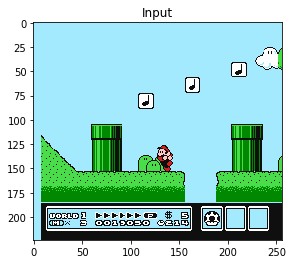

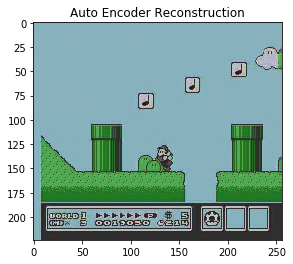

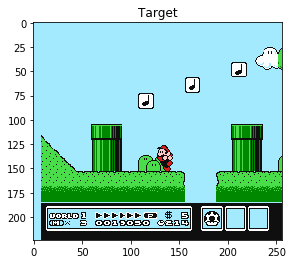

In [37]:
from visualize import visualize_outputs
# Gets the network's predictions about our image
input_image = DATASET[0]['image'].unsqueeze(0).to(DEVICE)
target_image = DATASET[0]['target'].unsqueeze(0)
print(type(input_image), input_image.shape)
reconstruction = MODEL(input_image)

visualize_outputs(input_image, titles=['Input'])
visualize_outputs(reconstruction, titles=['Auto Encoder Reconstruction'])
visualize_outputs(target_image, titles=['Target'])

#Save our Weights

So that we don't have to train all over again to re-use the model, let's save the state of the model. (This involves following instructions to link Google Drive Files and then getting the weights from Google Drive to wherever you may want them)

In [38]:
from google.colab import drive
drive.mount('/gdrive')
# Your save path may vary on drive
# %ls "/gdrive"
# %ls "/gdrive/My Drive"
save_file = "/gdrive/My Drive/unet-overfit-weights.pth"
print(save_file)
data_to_save = {
                'model': MODEL.state_dict(),
                'optimizer': optimizer.state_dict(),
                }
torch.save(data_to_save, save_file)
%ls "/gdrive/My Drive/unet-overfit-weights.pth"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/unet-overfit-weights.pth
'/gdrive/My Drive/unet-overfit-weights.pth'
